In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../Code')
from utils import save_adata, read_adata
from geneset_testing import load_geneset, fishertestbygep, mwtestbygep_ZES


import palettable
from IPython.display import display

from joblib import parallel_backend

from sklearn.preprocessing import scale
from scipy.stats import fisher_exact, mannwhitneyu, chi2_contingency, ttest_ind
from statsmodels.stats.multitest import multipletests

from matplotlib import gridspec

import mygene

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(scanpy=True, dpi=80, vector_friendly=False, ipython_format='png')

np.random.seed(14)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
import os

adir = '../../../../data/InVivo/Seqwell/'
project_name = 'invivo_all_20200318_mmul8_V4_fixid'
gcs = False
abase = os.path.join(adir, project_name)

count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'
abase

results_dir = '../../../../results'

In [4]:
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

## Obtain raw counts subsetted data for cells that passed all QC filters

In [5]:
adat_fn = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.EBOVcalls.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
adata = read_adata(adat_fn, gcs=gcs)

Only considering the two last: ['.EBOVcalls', '.h5ad'].
Only considering the two last: ['.EBOVcalls', '.h5ad'].


In [6]:
adata_raw = sc.AnnData(X=adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)
adata_raw.var['Combined_Blacklist'].value_counts()

False    16946
True       191
Name: Combined_Blacklist, dtype: int64

In [7]:
adata_raw = adata_raw[:, ~adata_raw.var['Combined_Blacklist']]
adata_raw.obs['is_fresh'] = adata_raw.obs['frz_status'].replace({'fresh':1, 'FRZ':0})

Trying to set attribute `.obs` of view, copying.


In [8]:
adata_raw

AnnData object with n_obs × n_vars = 56929 × 16946 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group', 'leiden_lab_2', 'leiden_lab_group_2', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'Subclustering_reduced', 'Soup_Usage', 'ebola_infection_threshold', 'Ebola_Positive', 'is_fresh'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', '

## Make basic plots of Ebola abundance levels in monocytes

In [9]:
ebovdat = adata_raw.obs.copy()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


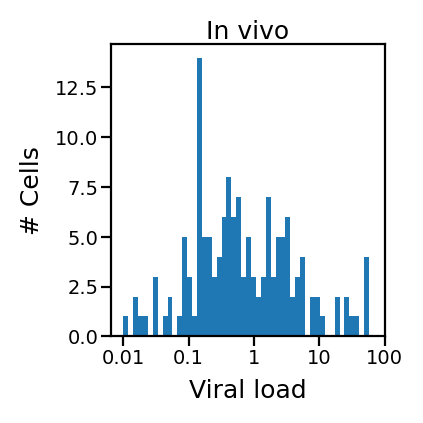

In [10]:
fig = plt.figure(constrained_layout=True, figsize=(2., 2.), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.95, top=.92)
ax = fig.add_subplot(gs[0],
                     xlabel='Viral load', ylabel='# Cells',
                     title='')

ind = (ebovdat['SubclusteringGroup']=='Mono') & (ebovdat['Ebola_Positive']==True) & ebovdat['DPIc'].isin(['4', '5', '6', '7','8'])

_ = ax.hist(np.log10(ebovdat.loc[ind, 'percent_EBOV']), bins=50)
ax.set_title('In vivo', pad=0)


ax.set_xticks([-4, -3, -2, -1,0])
ax.set_xticklabels(['0.01', '0.1', '1', '10','100'])
ax.grid(False)

figure_file = os.path.join(results_dir, "EbolaPercentTranscripts.Invivo.Histogram.pdf")
fig.savefig(figure_file, dpi=200)

In [11]:
ebovdat.loc[ind, 'percent_EBOV'].idxmin(), ebovdat.loc[ind, 'percent_EBOV'].min()

('NHP24.D006.FRZ-MDCK.a4.std_88_Novaseq_20190701_CTCAACGTCGGT', 0.00010019036)

In [12]:
ebovdat.loc['NHP24.D006.FRZ-MDCK.a4.std_88_Novaseq_20190701_CTCAACGTCGGT', :]

batch                        NHP24.D006.FRZ-MDCK.a4.std_88_Novaseq_20190701
DPI                                                                       6
DPIc                                                                      6
Period                                                                 Late
full_sample_id                                   NHP24.D006.FRZ-MDCK.a4.std
frz_status                                                              FRZ
sample_source                                                    NHP24.D006
sample                                                       NHP24.D006.FRZ
array_num                                                                a4
array_id                                             NHP24.D006.FRZ-MDCK.a4
animal                                                                NHP24
full_dash_status                                                        std
dash_status                                                             std
sample_dash 

In [13]:
ebovdat.loc[ind, 'percent_EBOV'].max()

0.5748731

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


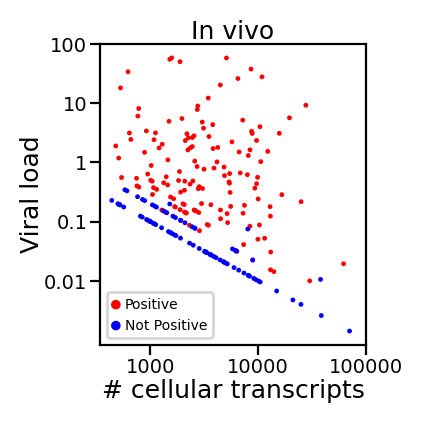

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(2.0, 2.0), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.95, top=.95)
ax = fig.add_subplot(gs[0],
                     ylabel='% EBOV Transcripts', xlabel='Total transcripts detected',
                     title='')

ind = ind = (ebovdat['SubclusteringGroup']=='Mono') & (ebovdat['EBOV_counts']>0) & ebovdat['DPIc'].isin(['4', '5', '6', '7','8'])  & (ebovdat['Ebola_Positive']==True)
ax.scatter(ebovdat.loc[ind, 'log_count'], ebovdat.loc[ind, 'percent_EBOV'].apply(np.log10), s=3, edgecolor='None', color='r', label='Positive')
ind = ind = (ebovdat['SubclusteringGroup']=='Mono') & (ebovdat['EBOV_counts']>0) & ebovdat['DPIc'].isin(['4', '5', '6', '7','8'])  & (ebovdat['Ebola_Positive']==False)
ax.scatter(ebovdat.loc[ind, 'log_count'], ebovdat.loc[ind, 'percent_EBOV'].apply(np.log10), s=3, edgecolor='None', color='b', label='Not Positive')

ax.set_xticks([3, 4, 5])
ax.set_xticklabels([1000, 10000, 100000])

ax.set_yticks([-4, -3, -2, -1, 0])
ax.set_yticklabels(['0.01', '0.1', '1', '10', '100'])
ax.legend(loc='lower left', markerscale=2, fontsize=5)
ax.set_title('In vivo', pad=0)
ax.set_ylabel('Viral load', labelpad=0)
ax.set_xlabel('# cellular transcripts', labelpad=1)
ax.grid(False)

figure_file = os.path.join(results_dir, "EbolaPercentVsLogUmi.Invivo.Scatter.pdf")
fig.savefig(figure_file, dpi=200)

## Output data for MAST differential expression testing of infected vs. bystander

In [15]:
adata_raw.obs['Subclustering_reduced']=='Mono'

NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACAAGACTT     False
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACACGCTTC     False
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACGAGATTA     False
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAAGTAGGTGG      True
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAATCGCTCCG     False
                                                                  ...  
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged_TTGTAACCGGGA    False
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged_TTGTTGGGCGCA     True
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged_TTTAAATGCGGC    False
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged_TTTCTTGCTCTT    False
NHP15.D003.fresh.a1.DASH-DASH2_88_NovaNext_Merged_TTTTAGCCTGCC    False
Name: Subclustering_reduced, Length: 56929, dtype: bool

In [16]:
pd.crosstab(adata_raw.obs['Subclustering_reduced'], adata_raw.obs['DPIc'])

DPIc,0,3,4,5,6,7,8
Subclustering_reduced,,,,,,,
B,1951,2848,962,1726,5922,89,7
Mono,736,3603,292,715,1562,53,15
NK,577,123,36,111,383,2,12
Neut,10,371,1396,256,2718,240,814
Plasmablast,42,53,8,15,115,17,16
Tc,1933,2163,238,2257,3474,51,166
Th,2855,4613,642,2741,7050,257,16
cDC,73,189,4,19,59,1,0
pDC,21,78,9,38,181,3,2


In [17]:
adir_local = '../../../../data/InVivo/Seqwell/'
dedir = os.path.join(adir_local, 'DE_Infection')
if not os.path.exists(dedir): os.mkdir(dedir)
    
de_infiles = os.path.join(dedir, 'genefiles')
if not os.path.exists(de_infiles): os.mkdir(de_infiles)
    
de_results = os.path.join(dedir, 'results')
if not os.path.exists(de_results): os.mkdir(de_results)

In [28]:
from sklearn.preprocessing import scale

mono_dpi5to8 = (adata_raw.obs['Subclustering_reduced']=='Mono') & (adata_raw.obs['DPIc'].isin(['5','6','7','8']))
mono_ebovread_nonpositive = (adata_raw.obs['Ebola_Positive']==False) & (adata_raw.obs['EBOV_counts']>0)
mono_totest = mono_dpi5to8 & ~mono_ebovread_nonpositive

display(pd.crosstab((adata_raw.obs.loc[mono_dpi5to8,'EBOV_counts']>0), adata_raw.obs.loc[mono_dpi5to8,'Ebola_Positive'] ))
display(mono_totest.value_counts())

adata_ct = adata_raw[mono_totest,:]
adata_ct.obs['is_fresh_scale'] = scale(adata_ct.obs['is_fresh'])
adata_ct.obs['percent_mito_scale'] = scale(adata_ct.obs['percent_mito'])
adata_ct.obs['Ebola_Positive_Binary'] = adata_ct.obs['Ebola_Positive'].astype(int)
        
sc.pp.filter_genes(adata_ct, min_cells=(.01*adata_ct.shape[0]))
adata_ct.obs['cngeneson'] =  scale((adata_ct.X>0).sum(axis=1)).reshape(-1)        

sc.pp.normalize_per_cell(adata_ct, counts_per_cell_after=10000)
sc.pp.log1p(adata_ct)
X = pd.DataFrame(adata_ct.X.todense(), index=adata_ct.obs.index, columns=adata_ct.var.index).T
X.to_csv(os.path.join(de_infiles, 'BystanderVsInfected.NoEBOVreadNegatives.expression.csv'))
adata_ct.obs.to_csv(os.path.join(de_infiles, 'BystanderVsInfected.NoEBOVreadNegatives.celldata.csv'))
adata_ct.var.to_csv(os.path.join(de_infiles, 'BystanderVsInfected.NoEBOVreadNegatives.genedata.csv'))

Ebola_Positive,False,True
EBOV_counts,,
False,2131,0
True,79,135


False    54663
True      2266
dtype: int64

Trying to set attribute `.obs` of view, copying.


filtered out 8136 genes that are detectedin less than 22.66 cells
normalizing by total count per cell


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [16]:
ncores =4
testvar = 'Ebola_Positive_Binary'
covars = ['is_fresh_scale', 'cngeneson', 'percent_mito_scale']
covarstr = ','.join(covars)

exprfn = os.path.join(de_infiles, 'BystanderVsInfected.NoEBOVreadNegatives.expression.csv')
celldatfn = os.path.join(de_infiles, 'BystanderVsInfected.NoEBOVreadNegatives.celldata.csv')
genedatfn = os.path.join(de_infiles, 'BystanderVsInfected.NoEBOVreadNegatives.genedata.csv')
resultsfn = os.path.join(de_results, 'BystanderVsInfected.NoEBOVreadNegatives.DE.csv')
cmd = 'Rscript ../../../Code/run_mast.R %s %s %s %s %d %s %s' % (exprfn, celldatfn, genedatfn, resultsfn, ncores, testvar, covarstr)
print(cmd)
!{cmd}

Rscript ../../../Code/run_mast.R ../../../../data/InVivo/Seqwell/DE_Infection/genefiles/BystanderVsInfected.NoEBOVreadNegatives.expression.csv ../../../../data/InVivo/Seqwell/DE_Infection/genefiles/BystanderVsInfected.NoEBOVreadNegatives.celldata.csv ../../../../data/InVivo/Seqwell/DE_Infection/genefiles/BystanderVsInfected.NoEBOVreadNegatives.genedata.csv ../../../../data/InVivo/Seqwell/DE_Infection/results/BystanderVsInfected.NoEBOVreadNegatives.DE.csv 4 Ebola_Positive_Binary is_fresh_scale,cngeneson,percent_mito_scale
~Ebola_Positive_Binary + is_fresh_scale + cngeneson + percent_mito_scale
`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name et is log-transformed.
 Completed [==========>---------------------------------]  25% with 0 failures
Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...
 Completed 

In [29]:
resultsfn = os.path.join(de_results, 'BystanderVsInfected.NoEBOVreadNegatives.DE.csv')

infVsby = pd.read_csv(resultsfn).sort_values(by='P_H')
infVsby.index = infVsby['primerid'].values
(_,q,_,_) = multipletests(infVsby['P_H'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
infVsby['Q'] = q
infVsby.head(20)

,primerid,logFC,P_H,P_C,P_D,Q
S100A8,S100A8,-2.031446,4.461840e-44,2.941037e-33,1.055477e-13,3.930881e-40
S100A9,S100A9,-2.016819,9.551066e-44,5.671494e-35,1.248295e-11,4.207245e-40
ADAMDEC1,ADAMDEC1,1.610543,1.583800e-33,6.526650e-17,1.999127e-19,4.533046e-30
NR1H3,NR1H3,0.881882,2.058136e-33,2.460906e-03,1.343855e-32,4.533046e-30
FTL,FTL,0.750957,2.393853e-32,1.401836e-30,2.397972e-04,4.217970e-29
FTH1,FTH1,1.112090,8.400672e-31,5.152724e-28,2.099675e-05,1.233499e-27
FCGR3,FCGR3,1.668877,1.036347e-30,5.757560e-16,1.615907e-17,1.304317e-27
SELL,SELL,-1.319994,1.439351e-26,1.440999e-05,1.383194e-23,1.585085e-23
C3,C3,1.208573,2.003192e-26,9.001479e-09,2.564704e-20,1.960902e-23
CTSH,CTSH,1.052056,1.125616e-25,3.100047e-21,4.625027e-07,9.916678e-23


In [30]:
(infVsby['Q']<.05).value_counts()

False    8305
True      505
Name: Q, dtype: int64

In [31]:
infsig = ((infVsby['Q']<.05) & (infVsby['logFC'].abs()>np.log(1.3)))
infsig.value_counts()

False    8543
True      267
dtype: int64

In [32]:
mergefn = '../../../../data/InVivo/Seqwell/DE_Stage/results/AllCT.AllPeriod.DE.Merged.csv'
stage_DE = pd.read_csv(mergefn, header=[0,1,2], index_col=0)
stage_sig = (stage_DE['Mono'].xs('Q', axis=1, level=1)<.05) & (stage_DE['Mono'].xs('logFC', axis=1, level=1).abs()>np.log(1.3))
is_stage_sig = (stage_sig.sum(axis=1)>0)
is_stage_sig.value_counts()

False    11289
True      1020
dtype: int64

In [33]:
len(set(is_stage_sig.index[is_stage_sig]).intersection(set(infsig.index[infsig])))

181

In [34]:
181 / 1020

0.17745098039215687

In [35]:
infVsby.loc['MX1', :]

primerid            MX1
logFC          -0.49899
P_H          2.5015e-16
P_C         4.36859e-11
P_D         9.82789e-08
Q           7.73045e-14
Name: MX1, dtype: object

In [36]:
infVsby['P_H'].isnull().value_counts()

False    8810
Name: P_H, dtype: int64

In [37]:
nullind = infVsby.loc[infVsby['logFC'].isnull() & ~infVsby['P_H'].isnull(), 'primerid']
infVsby.loc[nullind,:].head()

,primerid,logFC,P_H,P_C,P_D,Q
IL7,IL7,NaN,0.000089,1.0,0.000089,0.003152
NAPSA,NAPSA,NaN,0.000092,1.0,0.000092,0.003213
BCL2L15,BCL2L15,NaN,0.000249,1.0,0.000249,0.007149
ENSMMUG00000038383,ENSMMUG00000038383,NaN,0.000413,1.0,0.000413,0.010954
ENSMMUG00000020008,ENSMMUG00000020008,NaN,0.000647,1.0,0.000647,0.015714


In [38]:
nullind = infVsby.loc[infVsby['logFC'].isnull() & ~infVsby['P_H'].isnull(), 'primerid']

posind = adata_ct.obs.index[adata_ct.obs['Ebola_Positive_Binary']==True]
negind = adata_ct.obs.index[adata_ct.obs['Ebola_Positive_Binary']==False]

posval = X.loc[nullind, posind].mean(axis=1)
negval = X.loc[nullind, negind].mean(axis=1)

est_fc = np.log2((posval+.1) / (negval+.1))
est_fc

infVsby.index = infVsby['primerid']
infVsby.loc[est_fc.index,'logFC'] = est_fc.values

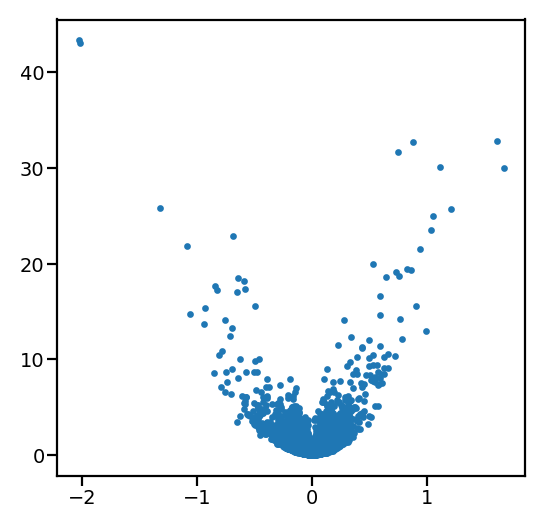

In [39]:
infVsby.index = infVsby['primerid']

(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
ax.scatter(infVsby.loc[:,'logFC'], infVsby.loc[:,'P_H'].apply(np.log10)*-1, s=2)
ax.grid(False)

## Append gene sets and perform gene set enrichment testing

### Dong et al 2013 - Gene

In [40]:
sig_genes_fn = '../../../../data/Genesets/InVitro_Macrophage_Differentiation/1-s2.0-S0378111913001911-mmc3.tsv'
mono2mac_siggenes = pd.read_csv(sig_genes_fn, sep='\t', skiprows=1)
mono2mac_siggenes = mono2mac_siggenes.iloc[:,:9]
mono2mac_siggenes.index = mono2mac_siggenes['gene symble']
ind = mono2mac_siggenes['gene symble'].isnull()
mono2mac_siggenes = mono2mac_siggenes.loc[~ind, :]
mono2mac_siggenes.head()

,gene symble,gene id,monocyte rpkm,macropahge rpkm,log2 (fold change),p value,q value,significant,gene description
gene symble,,,,,,,,,
SEPP1,SEPP1,NM_005410,0.038586,1484.570,15.2316,2.440000e-15,1.580000e-12,yes,"Homo sapiens selenoprotein P, plasma, 1 (SEPP1..."
C1QC,C1QC,NM_172369,0.091657,669.970,12.8356,0.000000e+00,0.000000e+00,yes,"Homo sapiens complement component 1, q subcomp..."
CHIT1,CHIT1,NM_003465,0.112905,648.777,12.4884,0.000000e+00,0.000000e+00,yes,Homo sapiens chitinase 1 (chitotriosidase) (CH...
TREM2,TREM2,NM_018965,0.174172,544.928,11.6113,0.000000e+00,0.000000e+00,yes,Homo sapiens triggering receptor expressed on ...
HAMP,HAMP,NM_021175,0.057351,170.176,11.5349,1.850000e-13,6.170000e-11,yes,Homo sapiens hepcidin antimicrobial peptide (H...


In [41]:
all_genes_mono_fn = '../../../../data/Genesets/InVitro_Macrophage_Differentiation/1-s2.0-S0378111913001911-mmc1.xlsx'
allgenes_mono = pd.ExcelFile(all_genes_mono_fn).parse(skiprows=1)
allgenes_mono = allgenes_mono.rename(columns={'RPKM':'RPKM_Mono'})
allgenes_mono.head()

,gene id,gene symble,RPKM_Mono
0,NR_045644,SMARCAD1,0.053401
1,NR_045639,UQCRB,0.737981
2,NR_045637,BOLA3-AS1,0.018934
3,NR_045634,BOLA3-AS1,0.144576
4,NR_045630,RGS5,0.109134


In [42]:
all_genes_mac_fn = '../../../../data/Genesets/InVitro_Macrophage_Differentiation/1-s2.0-S0378111913001911-mmc2.xls'
allgenes_mac = pd.ExcelFile(all_genes_mac_fn).parse(skiprows=1)
allgenes_mac = allgenes_mac.rename(columns={'RPKM':'RPKM_Mac'})
allgenes_mac.head()


,gene id,gene symble,RPKM_Mac
0,NM_000014,A2M,472.5260
1,NM_000016,ACADM,43.4457
2,NM_000017,ACADS,13.8303
3,NM_000018,ACADVL,73.4751
4,NM_000019,ACAT1,46.8797


In [43]:
allgenes = pd.merge(left=allgenes_mono, right=allgenes_mac.drop('gene symble', axis=1), how='outer', on=['gene id'])
allgenes.head()

,gene id,gene symble,RPKM_Mono,RPKM_Mac
0,NR_045644,SMARCAD1,0.053401,0.059605
1,NR_045639,UQCRB,0.737981,0.525734
2,NR_045637,BOLA3-AS1,0.018934,0.013074
3,NR_045634,BOLA3-AS1,0.144576,0.231261
4,NR_045630,RGS5,0.109134,0.318709


In [44]:
mono2mac_allgenes = pd.merge(left=allgenes,
                             right=mono2mac_siggenes[['gene id','gene symble', 'monocyte rpkm', 'macropahge rpkm',
       'log2 (fold change)', 'p value', 'q value', 'significant',
       'gene description']].rename(columns={'gene symble':'gene_symbol_sig'}),
                             on='gene id', how='outer')

mono2mac_allgenes['log2_FC'] = ((mono2mac_allgenes['RPKM_Mac'] +.1)/ (mono2mac_allgenes['RPKM_Mono']+.1)).apply(np.log2)
mono2mac_allgenes['significant'] = mono2mac_allgenes['significant'].replace(np.nan, 'no')
mono2mac_allgenes.head()

,gene id,gene symble,RPKM_Mono,RPKM_Mac,gene_symbol_sig,monocyte rpkm,macropahge rpkm,log2 (fold change),p value,q value,significant,gene description,log2_FC
0,NR_045644,SMARCAD1,0.053401,0.059605,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,0.057195
1,NR_045639,UQCRB,0.737981,0.525734,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,-0.421368
2,NR_045637,BOLA3-AS1,0.018934,0.013074,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,-0.072899
3,NR_045634,BOLA3-AS1,0.144576,0.231261,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,0.437686
4,NR_045630,RGS5,0.109134,0.318709,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,1.001520


In [45]:
mono2mac_allgenes['max_expr'] = mono2mac_allgenes[['RPKM_Mono', 'RPKM_Mac']].max(axis=1)
mono2mac_allgenes_dedup = mono2mac_allgenes.sort_values(by=['significant', 'max_expr'], ascending=[False, False]).drop_duplicates(subset=['gene symble'], keep='first')

In [46]:
mono2mac_allgenes_dedup['gene symble'].value_counts().head()

SNORA56    1
ULK4       1
DMPK       1
TMEM177    1
CTNNAL1    1
Name: gene symble, dtype: int64

In [47]:
mono2mac_allgenes_dedup['DongEtAl_Annotation'] = 'Not Significant'
ind = (mono2mac_allgenes_dedup['log2_FC']>0) & (mono2mac_allgenes_dedup['significant']=='yes')
mono2mac_allgenes_dedup.loc[ind, 'DongEtAl_Annotation'] = 'Significant Up'
ind = (mono2mac_allgenes_dedup['log2_FC']<0) & (mono2mac_allgenes_dedup['significant']=='yes')
mono2mac_allgenes_dedup.loc[ind, 'DongEtAl_Annotation'] = 'Significant Down'
mono2mac_allgenes_dedup.index = mono2mac_allgenes_dedup['gene symble']

In [48]:
mono2mac_allgenes_dedup.to_csv( '../../../../data/Genesets/InVitro_Macrophage_Differentiation/DongEtAl_Cleaned.tsv', sep='\t')

In [49]:
mono2mac_allgenes_dedup.head()

,gene id,gene symble,RPKM_Mono,RPKM_Mac,gene_symbol_sig,monocyte rpkm,macropahge rpkm,log2 (fold change),p value,q value,significant,gene description,log2_FC,max_expr,DongEtAl_Annotation
gene symble,,,,,,,,,,,,,,,
RN5-8S1,NR_003285,RN5-8S1,7122.5100,181109.000,RN5-8S1,7122.5100,181109.000,4.66833,1.830000e-07,9.700000e-06,yes,"Homo sapiens RNA, tRNaseZL-interacting RNA B1.",4.668309,181109.00,Significant Up
CD52,NM_001803,CD52,222.5630,4781.110,CD52,222.5630,4781.110,4.42506,9.420000e-06,2.811920e-04,yes,"Homo sapiens CD52 molecule (CD52), mRNA.",4.424442,4781.11,Significant Up
TIMP1,NM_003254,TIMP1,4426.4200,247.507,TIMP1,4426.4200,247.507,-4.16060,5.140000e-05,1.163400e-03,yes,Homo sapiens TIMP metallopeptidase inhibitor 1...,-4.160049,4426.42,Significant Down
APOC1,NM_001645,APOC1,2.7070,4015.170,APOC1,2.7070,4015.170,10.53460,0.000000e+00,0.000000e+00,yes,"Homo sapiens apolipoprotein C-I (APOC1), mRNA.",10.482252,4015.17,Significant Up
RNASE1,NM_002933,RNASE1,23.4677,3424.530,RNASE1,23.4677,3424.530,7.18909,5.060000e-10,5.920000e-08,yes,"Homo sapiens ribonuclease, RNase A family, 1 (...",7.182993,3424.53,Significant Up


In [50]:
q_thresh = 0.1
infVsby['Infection_DE_Annotation'] = 'Not Significant'
ind = (infVsby['Q']<q_thresh) & (infVsby['logFC']>0)
infVsby.loc[ind, 'Infection_DE_Annotation'] = 'Significant Up'
ind = (infVsby['Q']<q_thresh) & (infVsby['logFC']<0)
infVsby.loc[ind, 'Infection_DE_Annotation'] = 'Significant Down'
infVsby.head()

,primerid,logFC,P_H,P_C,P_D,Q,Infection_DE_Annotation
primerid,,,,,,,
S100A8,S100A8,-2.031446,4.461840e-44,2.941037e-33,1.055477e-13,3.930881e-40,Significant Down
S100A9,S100A9,-2.016819,9.551066e-44,5.671494e-35,1.248295e-11,4.207245e-40,Significant Down
ADAMDEC1,ADAMDEC1,1.610543,1.583800e-33,6.526650e-17,1.999127e-19,4.533046e-30,Significant Up
NR1H3,NR1H3,0.881882,2.058136e-33,2.460906e-03,1.343855e-32,4.533046e-30,Significant Up
FTL,FTL,0.750957,2.393853e-32,1.401836e-30,2.397972e-04,4.217970e-29,Significant Up


In [51]:
infVsby_m1 = pd.merge(left=infVsby, right=mono2mac_allgenes_dedup[['DongEtAl_Annotation']], left_index=True, right_index=True, how='left')
infVsby_m1.head()

,primerid,logFC,P_H,P_C,P_D,Q,Infection_DE_Annotation,DongEtAl_Annotation
primerid,,,,,,,,
S100A8,S100A8,-2.031446,4.461840e-44,2.941037e-33,1.055477e-13,3.930881e-40,Significant Down,Significant Down
S100A9,S100A9,-2.016819,9.551066e-44,5.671494e-35,1.248295e-11,4.207245e-40,Significant Down,Not Significant
ADAMDEC1,ADAMDEC1,1.610543,1.583800e-33,6.526650e-17,1.999127e-19,4.533046e-30,Significant Up,Significant Up
NR1H3,NR1H3,0.881882,2.058136e-33,2.460906e-03,1.343855e-32,4.533046e-30,Significant Up,Significant Up
FTL,FTL,0.750957,2.393853e-32,1.401836e-30,2.397972e-04,4.217970e-29,Significant Up,Not Significant


In [55]:
infVsby_m1['DongEtAl_Annotation'].replace(np.nan, 'null').value_counts()

Not Significant     6674
null                1453
Significant Up       434
Significant Down     249
Name: DongEtAl_Annotation, dtype: int64

In [57]:
ind = ~infVsby_m1['DongEtAl_Annotation'].isnull()
ct = pd.crosstab(infVsby_m1.loc[ind, 'Infection_DE_Annotation']=='Significant Up',  infVsby_m1.loc[ind, 'DongEtAl_Annotation']=='Significant Up')

ct.index = [str(x) for x in ct.index]
ct.columns = [str(x) for x in ct.columns]
ct = ct.loc[['True', 'False'],['True', 'False']]

print('Up - up enrichment. OR=%.3f. P=%.2e' % fisher_exact(ct))

ct

Up - up enrichment. OR=3.448. P=3.10e-11


,True,False
True,48,241
False,386,6682


In [58]:
ct = pd.crosstab(infVsby_m1.loc[ind, 'Infection_DE_Annotation']=='Significant Down',  infVsby_m1.loc[ind, 'DongEtAl_Annotation']=='Significant Down')
ct.index = [str(x) for x in ct.index]
ct.columns = [str(x) for x in ct.columns]
ct = ct.loc[['True', 'False'],['True', 'False']]
display(ct)
print('Down - down enrichment. OR=%.3f. P=%.2e' % fisher_exact(ct))

,True,False
True,29,247
False,220,6861


Down - down enrichment. OR=3.662. P=4.21e-08


In [39]:
ct = pd.crosstab(infVsby_m1.loc[ind, 'Infection_DE_Annotation'].isin(['Significant Up', 'Significant Down']),
                 infVsby_m1.loc[ind, 'DongEtAl_Annotation'].isin(['Significant Up', 'Significant Down']))
ct.index = [str(x) for x in ct.index]
ct.columns = [str(x) for x in ct.columns]
ct = ct.loc[['True', 'False'],['True', 'False']]
display(ct)
print('Sig - Sig enrichment. OR=%.3f. P=%.2e' % fisher_exact(ct))

,True,False
True,129,436
False,554,6238


Sig - Sig enrichment. OR=3.331. P=5.11e-24


In [59]:

ct = pd.crosstab(infVsby_m1.loc[ind, 'Infection_DE_Annotation'], infVsby_m1.loc[ind, 'DongEtAl_Annotation'])
display(ct)
res = chi2_contingency(ct, correction=True)
print('Chi2 GOF test. Chi2=%.3f. P=%.2e' % (res[0], res[1]))

DongEtAl_Annotation,Not Significant,Significant Down,Significant Up
Infection_DE_Annotation,,,
Not Significant,6238,200,354
Significant Down,215,29,32
Significant Up,221,20,48


Chi2 GOF test. Chi2=145.148. P=2.23e-30


### Saeed et al 2014, Science

In [60]:
gefn = '../../../../data/Genesets/InVitro_Macrophage_Differentiation/GSE58310_GeneExpression.csv'
ge = pd.read_csv(gefn, index_col=0)
ge.head()

,Monocytes_0d_RPMI_BC8_4639,Monocytes_0d_RPMI_BC9_4817,Monocytes_0d_RPMI_BC11_5383,Monocytes_0d_RPMI_BC12_5387,Monocytes_6d_RPMI_BC8_4640,Monocytes_6d_RPMI_BC9_4818,Monocytes_6d_RPMI_BC11_5384,Monocytes_6d_RPMI_BC12_5388,Monocytes_6d_LPS_BC8_4641,Monocytes_6d_LPS_BC9_4819,Monocytes_6d_LPS_BC11_5385,Monocytes_6d_LPS_BC12_5389,Monocytes_6d_BG_BC8_4642,Monocytes_6d_BG_BC9_4820,Monocytes_6d_BG_BC11_5386,Monocytes_6d_BG_BC12_5390
feature_id,,,,,,,,,,,,,,,,
ENSG00000000003,-2.293730,-6.242800,-6.201270,-2.698030,0.744415,-0.133723,-6.39470,-2.37179,-4.979200,-6.52326,-6.312760,-6.04711,-0.123453,0.912869,-6.31620,-1.75714
ENSG00000000005,-8.422350,-7.959820,-7.809210,-7.753300,-7.729490,-7.999750,-8.04761,-7.92664,-7.284030,-8.06749,-3.214780,-7.70588,-8.370600,-8.003620,-7.87073,-7.61691
ENSG00000000419,3.486450,4.372420,3.914770,3.882210,4.023620,4.410740,3.57659,3.45075,3.688900,4.35468,3.762470,3.81627,4.155390,4.637640,3.76253,3.57118
ENSG00000000457,-0.381178,0.761667,0.149427,0.036309,1.458420,1.796380,1.71358,1.96107,1.984750,2.24949,1.607110,1.94917,1.394270,1.829600,1.46852,1.60002
ENSG00000000460,0.311245,0.592428,0.072641,0.040819,1.054730,1.141990,1.34956,1.36171,0.715462,1.73925,0.973712,1.47592,1.609290,1.614040,1.22829,1.15452


In [61]:
mono = ['Monocytes_0d_RPMI_BC8_4639', 'Monocytes_0d_RPMI_BC9_4817',
       'Monocytes_0d_RPMI_BC11_5383', 'Monocytes_0d_RPMI_BC12_5387']

mac = ['Monocytes_6d_RPMI_BC8_4640', 'Monocytes_6d_RPMI_BC9_4818',
       'Monocytes_6d_RPMI_BC11_5384', 'Monocytes_6d_RPMI_BC12_5388']

ge['Mo_RPKM_Mean'] = ge.loc[:,mono].mean(axis=1)
ge['Mf_RPKM_Mean'] = ge.loc[:,mac].mean(axis=1)
ge['logFC'] = ge['Mf_RPKM_Mean'] - ge['Mo_RPKM_Mean']

allres = ttest_ind(ge.loc[:, mac], ge.loc[:, mono], axis=1, equal_var=False)
ge['Ttest_Stat'] = allres.statistic
ge['Ttest_P'] = allres.pvalue

ge['ensemblid'] = ge.index
ge.head()

,Monocytes_0d_RPMI_BC8_4639,Monocytes_0d_RPMI_BC9_4817,Monocytes_0d_RPMI_BC11_5383,Monocytes_0d_RPMI_BC12_5387,Monocytes_6d_RPMI_BC8_4640,Monocytes_6d_RPMI_BC9_4818,Monocytes_6d_RPMI_BC11_5384,Monocytes_6d_RPMI_BC12_5388,Monocytes_6d_LPS_BC8_4641,Monocytes_6d_LPS_BC9_4819,...,Monocytes_6d_BG_BC8_4642,Monocytes_6d_BG_BC9_4820,Monocytes_6d_BG_BC11_5386,Monocytes_6d_BG_BC12_5390,Mo_RPKM_Mean,Mf_RPKM_Mean,logFC,Ttest_Stat,Ttest_P,ensemblid
feature_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,-2.293730,-6.242800,-6.201270,-2.698030,0.744415,-0.133723,-6.39470,-2.37179,-4.979200,-6.52326,...,-0.123453,0.912869,-6.31620,-1.75714,-4.358957,-2.038950,2.320008,1.205746,0.279216,ENSG00000000003
ENSG00000000005,-8.422350,-7.959820,-7.809210,-7.753300,-7.729490,-7.999750,-8.04761,-7.92664,-7.284030,-8.06749,...,-8.370600,-8.003620,-7.87073,-7.61691,-7.986170,-7.925872,0.060297,0.360704,0.735651,ENSG00000000005
ENSG00000000419,3.486450,4.372420,3.914770,3.882210,4.023620,4.410740,3.57659,3.45075,3.688900,4.35468,...,4.155390,4.637640,3.76253,3.57118,3.913963,3.865425,-0.048538,-0.170567,0.870365,ENSG00000000419
ENSG00000000457,-0.381178,0.761667,0.149427,0.036309,1.458420,1.796380,1.71358,1.96107,1.984750,2.24949,...,1.394270,1.829600,1.46852,1.60002,0.141556,1.732363,1.590806,6.158357,0.003154,ENSG00000000457
ENSG00000000460,0.311245,0.592428,0.072641,0.040819,1.054730,1.141990,1.34956,1.36171,0.715462,1.73925,...,1.609290,1.614040,1.22829,1.15452,0.254283,1.226997,0.972714,6.530651,0.001359,ENSG00000000460


In [62]:
orthology_fn = '../../../../data/misc/ensembl99_orthology_macaque2human_IDs_20200318.tsv'
orthology = pd.read_csv(orthology_fn, sep='\t')
orthology = orthology[['Human gene stable ID', 'Gene stable ID', '%id. target Human gene identical to query gene']].dropna()
orthology.head()

,Human gene stable ID,Gene stable ID,%id. target Human gene identical to query gene
0,ENSG00000185220,ENSMMUG00000023296,98.9865
2,ENSG00000171163,ENSMMUG00000000634,97.8805
3,ENSG00000171163,ENSMMUG00000000634,97.8805
4,ENSG00000171163,ENSMMUG00000000634,97.8805
5,ENSG00000171161,ENSMMUG00000037875,97.7876


In [63]:
ge_macaque_orthologue = pd.merge(left=ge, right=orthology, left_index=True, right_on='Human gene stable ID', how='left')

In [64]:
macaque_2_ortholog = []
for (i,g) in enumerate(adata_ct.var.index):
    for c in adata_ct.var.loc[g, 'gene_id'].split(','):
        macaque_2_ortholog.append([g, c])
macaque_2_ortholog = pd.DataFrame(macaque_2_ortholog, columns=['macaque_genesym', 'macaque_geneid'])
macaque_2_ortholog.head()


,macaque_genesym,macaque_geneid
0,CCNF,ENSMMUG00000000001
1,TEDC2,ENSMMUG00000000002
2,NAGA,ENSMMUG00000000005
3,BET1,ENSMMUG00000000007
4,PTPRC,ENSMMUG00000000009


In [65]:
ge_macaque_orthologue_indataset = pd.merge(left=ge_macaque_orthologue, right=macaque_2_ortholog, left_on='Gene stable ID', right_on='macaque_geneid', how='left')

In [66]:
ge_macaque_orthologue_indataset = ge_macaque_orthologue_indataset.loc[~ge_macaque_orthologue_indataset['macaque_geneid'].isnull(), :]

In [67]:
ge_macaque_orthologue_indataset_dedup = ge_macaque_orthologue_indataset.sort_values(by='%id. target Human gene identical to query gene', ascending=False).drop_duplicates(subset='macaque_genesym', keep='first')

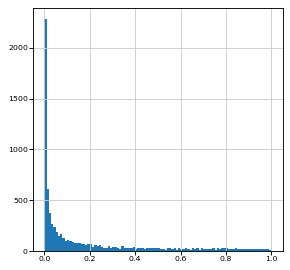

In [68]:
_ = plt.hist(ge_macaque_orthologue_indataset_dedup['Ttest_P'], bins=100)

In [69]:
(_,q,_,_) = multipletests(ge_macaque_orthologue_indataset_dedup['Ttest_P'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
ge_macaque_orthologue_indataset_dedup['Ttest_Q'] = q

q_thresh = .1
ge_macaque_orthologue_indataset_dedup['SaeedEtAl_Annotation'] = 'Not Significant'
ind = (ge_macaque_orthologue_indataset_dedup['logFC']>0) & (ge_macaque_orthologue_indataset_dedup['Ttest_Q']<q_thresh)
ge_macaque_orthologue_indataset_dedup.loc[ind, 'SaeedEtAl_Annotation'] = 'Significant Up'
ind = (ge_macaque_orthologue_indataset_dedup['logFC']<0) & (ge_macaque_orthologue_indataset_dedup['Ttest_Q']<q_thresh)
ge_macaque_orthologue_indataset_dedup.loc[ind, 'SaeedEtAl_Annotation'] = 'Significant Down'
ge_macaque_orthologue_indataset_dedup.index = ge_macaque_orthologue_indataset_dedup['macaque_genesym']

In [70]:
ge_macaque_orthologue_indataset_dedup = ge_macaque_orthologue_indataset_dedup[['Mo_RPKM_Mean', 'Mf_RPKM_Mean', 'logFC', 'Ttest_Stat', 'Ttest_P',
       'ensemblid', 'Human gene stable ID',
       '%id. target Human gene identical to query gene', 'macaque_genesym',
       'macaque_geneid', 'Ttest_Q', 'SaeedEtAl_Annotation']]

In [71]:
ge_macaque_orthologue_indataset_dedup.head()

,Mo_RPKM_Mean,Mf_RPKM_Mean,logFC,Ttest_Stat,Ttest_P,ensemblid,Human gene stable ID,%id. target Human gene identical to query gene,macaque_genesym,macaque_geneid,Ttest_Q,SaeedEtAl_Annotation
macaque_genesym,,,,,,,,,,,,
RBM22,3.904970,3.363730,-0.541240,-4.066168,0.020464,ENSG00000086589,ENSG00000086589,100.0,RBM22,ENSMMUG00000020683,0.052217,Significant Down
FAM32A,3.476045,4.273093,0.797048,3.333687,0.038739,ENSG00000105058,ENSG00000105058,100.0,FAM32A,ENSMMUG00000013076,0.082264,Significant Up
SNURF,1.738607,1.080897,-0.657710,-1.534294,0.191700,ENSG00000128739,ENSG00000128739,100.0,SNURF,ENSMMUG00000023139,0.271776,Not Significant
DDX3X,5.883808,5.221120,-0.662688,-2.885912,0.042004,ENSG00000215301,ENSG00000215301,100.0,DDX3X,ENSMMUG00000017569,0.086887,Significant Down
ORMDL1,3.648965,4.324825,0.675860,3.264303,0.018147,ENSG00000128699,ENSG00000128699,100.0,ORMDL1,ENSMMUG00000014316,0.048145,Significant Up


In [72]:
ge_macaque_orthologue_indataset_dedup.to_csv( '../../../../data/Genesets/InVitro_Macrophage_Differentiation/SaeedEtAl_Cleaned.tsv', sep='\t')

In [73]:
infVsby_m2 = pd.merge(left=infVsby_m1, right=ge_macaque_orthologue_indataset_dedup[['SaeedEtAl_Annotation']], left_index=True, right_index=True, how='left')
infVsby_m2.head()

,primerid,logFC,P_H,P_C,P_D,Q,Infection_DE_Annotation,DongEtAl_Annotation,SaeedEtAl_Annotation
primerid,,,,,,,,,
S100A8,S100A8,-2.031446,4.461840e-44,2.941037e-33,1.055477e-13,3.930881e-40,Significant Down,Significant Down,Significant Down
S100A9,S100A9,-2.016819,9.551066e-44,5.671494e-35,1.248295e-11,4.207245e-40,Significant Down,Not Significant,Significant Down
ADAMDEC1,ADAMDEC1,1.610543,1.583800e-33,6.526650e-17,1.999127e-19,4.533046e-30,Significant Up,Significant Up,Significant Up
NR1H3,NR1H3,0.881882,2.058136e-33,2.460906e-03,1.343855e-32,4.533046e-30,Significant Up,Significant Up,Significant Up
FTL,FTL,0.750957,2.393853e-32,1.401836e-30,2.397972e-04,4.217970e-29,Significant Up,Not Significant,Significant Up


In [55]:
infVsby_m2['SaeedEtAl_Annotation'].replace(np.nan, 'null').value_counts()

Not Significant     3632
Significant Up      2570
null                1384
Significant Down    1224
Name: SaeedEtAl_Annotation, dtype: int64

In [89]:
ind = ~infVsby_m2['SaeedEtAl_Annotation'].isnull()
ct = pd.crosstab(infVsby_m2.loc[ind, 'Infection_DE_Annotation']=='Significant Up',  infVsby_m2.loc[ind, 'SaeedEtAl_Annotation']=='Significant Up')

ct.index = [str(x) for x in ct.index]
ct.columns = [str(x) for x in ct.columns]
ct = ct.loc[['True', 'False'],['True', 'False']]

print('Saeed et al Up - up enrichment. OR=%.3f. P=%.2e' % fisher_exact(ct))

ct

Saeed et al Up - up enrichment. OR=1.466. P=2.21e-03


,True,False
True,123,161
False,2447,4695


In [90]:
ct = pd.crosstab(infVsby_m2.loc[ind, 'Infection_DE_Annotation']=='Significant Down',  infVsby_m2.loc[ind, 'SaeedEtAl_Annotation']=='Significant Down')
ct.index = [str(x) for x in ct.index]
ct.columns = [str(x) for x in ct.columns]
ct = ct.loc[['True', 'False'],['True', 'False']]
display(ct)
print('Saeed et al Down - down enrichment. OR=%.3f. P=%.2e' % fisher_exact(ct))

,True,False
True,73,193
False,1151,6009


Saeed et al Down - down enrichment. OR=1.975. P=4.42e-06


In [91]:
ct = pd.crosstab(infVsby_m2.loc[ind, 'Infection_DE_Annotation'].isin(['Significant Up', 'Significant Down']),
                 infVsby_m2.loc[ind, 'SaeedEtAl_Annotation'].isin(['Significant Up', 'Significant Down']))
ct.index = [str(x) for x in ct.index]
ct.columns = [str(x) for x in ct.columns]
ct = ct.loc[['True', 'False'],['True', 'False']]
display(ct)
print('Saeed et al Sig - Sig enrichment. OR=%.3f. P=%.2e' % fisher_exact(ct))

,True,False
True,292,258
False,3502,3374


Saeed et al Sig - Sig enrichment. OR=1.090. P=3.52e-01


In [93]:

ct = pd.crosstab(infVsby_m2.loc[ind, 'Infection_DE_Annotation'], infVsby_m2.loc[ind, 'SaeedEtAl_Annotation'])
display(ct)
res = chi2_contingency(ct, correction=True)
print('Chi2 GOF test. Chi2=%.3f. P=%.2e' % (res[0], res[1]))

SaeedEtAl_Annotation,Not Significant,Significant Down,Significant Up
Infection_DE_Annotation,,,
Not Significant,3374,1109,2393
Significant Down,139,73,54
Significant Up,119,42,123


Chi2 GOF test. Chi2=45.925. P=2.55e-09


### Italiani et al 2014

In [94]:
m1 = pd.ExcelFile('../../../../data/Genesets/InVitro_Macrophage_Differentiation/ItalianiEtAl_M1vsMono.xlsx').parse()
m2 = pd.ExcelFile('../../../../data/Genesets/InVitro_Macrophage_Differentiation/ItalianiEtAl_M2vsMono.xlsx').parse()

In [95]:
m1.head()

,Gene Id,Symbol,Description
0,GC08P019841_at,LPL,lipoprotein lipase
1,GC04P089115_at,SPP1,secreted phosphoprotein 1
2,GC08P081561_at,ZBTB10,zinc finger and BTB domain containing 10
3,GC05M158674_at,IL12B,interleukin 12B (natural killer cell stimulato...
4,GC08P086563_at,CA2,carbonic anhydrase II


In [96]:
m2.head()

,Gene Id,Symbol,Description
0,GC08P024297_at,ADAMDEC1,"ADAM-like, decysin 1"
1,GC03M058153_at,DNASE1L3,deoxyribonuclease I-like 3
2,GC12M045755_at,AMIGO2,adhesion molecule with Ig-like domain 2
3,GC01M160219_at,OLFML2B,olfactomedin-like 2B
4,GC01M111827_at,ADORA3,adenosine A3 receptor


In [97]:
infVsby_m3 = infVsby_m2.copy()
infVsby_m3.head()

,primerid,logFC,P_H,P_C,P_D,Q,Infection_DE_Annotation,DongEtAl_Annotation,SaeedEtAl_Annotation
primerid,,,,,,,,,
S100A8,S100A8,-2.031446,4.461840e-44,2.941037e-33,1.055477e-13,3.930881e-40,Significant Down,Significant Down,Significant Down
S100A9,S100A9,-2.016819,9.551066e-44,5.671494e-35,1.248295e-11,4.207245e-40,Significant Down,Not Significant,Significant Down
ADAMDEC1,ADAMDEC1,1.610543,1.583800e-33,6.526650e-17,1.999127e-19,4.533046e-30,Significant Up,Significant Up,Significant Up
NR1H3,NR1H3,0.881882,2.058136e-33,2.460906e-03,1.343855e-32,4.533046e-30,Significant Up,Significant Up,Significant Up
FTL,FTL,0.750957,2.393853e-32,1.401836e-30,2.397972e-04,4.217970e-29,Significant Up,Not Significant,Significant Up


In [98]:
infVsby_m3['Italiani_M1_gene'] = infVsby_m3['primerid'].isin(m1['Symbol'])
infVsby_m3['Italiani_M2_gene'] = infVsby_m3['primerid'].isin(m2['Symbol'])
infVsby_m3['Italiani_M1orM2_gene'] = infVsby_m3['Italiani_M1_gene'] | infVsby_m3['Italiani_M2_gene'] 

In [99]:
infVsby_m3.head()

,primerid,logFC,P_H,P_C,P_D,Q,Infection_DE_Annotation,DongEtAl_Annotation,SaeedEtAl_Annotation,Italiani_M1_gene,Italiani_M2_gene,Italiani_M1orM2_gene
primerid,,,,,,,,,,,,
S100A8,S100A8,-2.031446,4.461840e-44,2.941037e-33,1.055477e-13,3.930881e-40,Significant Down,Significant Down,Significant Down,False,True,True
S100A9,S100A9,-2.016819,9.551066e-44,5.671494e-35,1.248295e-11,4.207245e-40,Significant Down,Not Significant,Significant Down,False,False,False
ADAMDEC1,ADAMDEC1,1.610543,1.583800e-33,6.526650e-17,1.999127e-19,4.533046e-30,Significant Up,Significant Up,Significant Up,False,True,True
NR1H3,NR1H3,0.881882,2.058136e-33,2.460906e-03,1.343855e-32,4.533046e-30,Significant Up,Significant Up,Significant Up,False,True,True
FTL,FTL,0.750957,2.393853e-32,1.401836e-30,2.397972e-04,4.217970e-29,Significant Up,Not Significant,Significant Up,False,False,False


In [102]:
print('\n'.join(infVsby_m3.index[infVsby_m3['Italiani_M2_gene']==True]))

S100A8
ADAMDEC1
NR1H3
SELL
CTSC
CPM
VCAN
GPNMB
LGMN
PLAC8
C1QB
RGS2
SLC1A3
MS4A4A
RNASE2
CYP51A1
SLCO4C1
VNN2
TNFSF10
THBS1
PDE4B
MAOA
SLC38A6
SIK1
TFPI
SLC47A1
ICAM3
CTSK
NUPR1
CHST2
PLTP
NR4A2
CCL23
NPC1
PF4
CD69
IFI44L
DUSP6
OSBPL1A
S100A12
CD93
MXD1
MARCKSL1
EGR1
TREM2
CRISPLD2
FOSB
DENND4C
EREG
CD59
FAH
NLRP3
PMP22
A2M
HPSE
FYN


In [103]:
ct = pd.crosstab(infVsby_m3.loc[:, 'Infection_DE_Annotation'].isin(['Significant Up', 'Significant Down']),
                 infVsby_m3.loc[:, 'Italiani_M1_gene'])
ct.index = [str(x) for x in ct.index]
ct.columns = [str(x) for x in ct.columns]
ct = ct.loc[['True', 'False'],['True', 'False']]
display(ct)
print('Italiani et al Sig - Sig M1 enrichment. OR=%.3f. P=%.2e' % fisher_exact(ct))

,True,False
True,11,637
False,43,8119


Italiani et al Sig - Sig M1 enrichment. OR=3.261. P=1.62e-03


In [106]:
ct = pd.crosstab(infVsby_m3.loc[:, 'Infection_DE_Annotation'].isin(['Significant Up', 'Significant Down']),
                 infVsby_m3.loc[:, 'Italiani_M2_gene'])
ct.index = [str(x) for x in ct.index]
ct.columns = [str(x) for x in ct.columns]
ct = ct.loc[['True', 'False'],['True', 'False']]
display(ct)
print('Italiani et al Sig - Sig M2 enrichment. OR=%.3f. P=%.2e' % fisher_exact(ct))

,True,False
True,21,627
False,35,8127


Italiani et al Sig - Sig M2 enrichment. OR=7.777. P=1.33e-10


In [105]:
ct = pd.crosstab(infVsby_m3.loc[:, 'Infection_DE_Annotation'].isin(['Significant Up', 'Significant Down']),
                 infVsby_m3.loc[:, 'Italiani_M1orM2_gene'])
ct.index = [str(x) for x in ct.index]
ct.columns = [str(x) for x in ct.columns]
ct = ct.loc[['True', 'False'],['True', 'False']]
display(ct)
print('Italiani et al Sig - Sig M1 or M2 enrichment. OR=%.3f. P=%.2e' % fisher_exact(ct))

,True,False
True,32,616
False,78,8084


Italiani et al Sig - Sig M1 or M2 enrichment. OR=5.384. P=5.67e-12


## Make volcano plot

In [69]:
gsetfn = '../../../../data/Genesets/msigdb/c2andh.all.v6.2.symbols.gmt'
gset_c2andH, allgenes = load_geneset(gsetfn,  genes=list(infVsby_m3.index), minsize=10)

literature_interferon = gset_c2andH['HECKER_IFNB1_TARGETS'].union(gset_c2andH['BROWNE_INTERFERON_RESPONSIVE_GENES']).union(gset_c2andH['MOSERLE_IFNA_RESPONSE']).union(gset_c2andH['HALLMARK_INTERFERON_ALPHA_RESPONSE']).union(gset_c2andH['HALLMARK_INTERFERON_GAMMA_RESPONSE'])
len(literature_interferon)

220

In [70]:
infVsby_m3['ISG'] = infVsby_m3['primerid'].isin(literature_interferon)

In [71]:
infVsby_m3 = infVsby_m3.rename(columns={'primerid':'gene_symbol'})


In [72]:
infVsby_m3['Annotation'] = 'Other'


ind = (infVsby_m3['DongEtAl_Annotation'] == 'Significant Down') | (infVsby_m3['SaeedEtAl_Annotation'] == 'Significant Down')
ind = ind & ~(infVsby_m3['DongEtAl_Annotation'] == 'Significant Up') & ~(infVsby_m3['SaeedEtAl_Annotation'] == 'Significant Up') 
infVsby_m3.loc[ind, 'Annotation'] = 'Mac. Down'

ind = (infVsby_m3['ISG'] == True)
infVsby_m3.loc[ind, 'Annotation'] = 'ISG'

ind = (infVsby_m3['DongEtAl_Annotation'] == 'Significant Up') | (infVsby_m3['SaeedEtAl_Annotation'] == 'Significant Up')
ind = ind & ~(infVsby_m3['DongEtAl_Annotation'] == 'Significant Down') & ~(infVsby_m3['SaeedEtAl_Annotation'] == 'Significant Down') 
infVsby_m3.loc[ind, 'Annotation'] = 'Mac. Up'

ind = infVsby_m3['gene_symbol'].isin(['FCGR3', 'CD14'])
infVsby_m3.loc[ind, 'Annotation'] = 'Marker'

In [73]:
other_to_check = ['MX1', 'MX2', 'MNDA', 'MKI67', 'SELL', 'C1QC']
infVsby_m3.loc[other_to_check, :]

,gene_symbol,logFC,P_H,P_C,P_D,Q,Infection_DE_Annotation,DongEtAl_Annotation,SaeedEtAl_Annotation,Italiani_M1_gene,Italiani_M2_gene,Italiani_M1orM2_gene,ISG,Annotation
primerid,,,,,,,,,,,,,,
MX1,MX1,-0.498990,2.501497e-16,4.368592e-11,9.827888e-08,7.730453e-14,Significant Down,Significant Down,Significant Down,False,False,False,True,ISG
MX2,MX2,-0.481345,2.489802e-09,5.086232e-05,1.455100e-06,3.046550e-07,Significant Down,Significant Down,Significant Down,False,False,False,True,ISG
MNDA,MNDA,-0.594048,6.910158e-19,5.329952e-14,2.005182e-07,2.767204e-16,Significant Down,Not Significant,NaN,False,False,False,False,Other
MKI67,MKI67,-0.826827,5.514636e-18,2.034490e-01,1.105633e-18,1.943358e-15,Significant Down,Significant Up,Not Significant,False,False,False,False,Mac. Up
SELL,SELL,-1.319994,1.439351e-26,1.440999e-05,1.383194e-23,1.585085e-23,Significant Down,Significant Down,Significant Down,False,True,True,True,ISG
C1QC,C1QC,0.531828,1.132602e-20,4.907784e-01,1.185958e-21,6.652150e-18,Significant Up,Significant Up,Significant Up,False,False,False,True,Mac. Up


In [74]:
# Cell cycle
infVsby_m3.loc['MKI67', 'Annotation'] = 'Other'

## MNDA - ISG
#- https://www.ncbi.nlm.nih.gov/gene/4332
infVsby_m3.loc['MNDA', 'Annotation'] = 'ISG'

infVsby_m3.loc['SELL', 'Annotation'] = 'Mac. Down'

infVsby_m3.loc['C1QC', 'Annotation'] = 'Mac. Up'


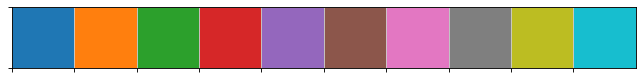

In [77]:
sns.palplot(palettable.tableau.Tableau_10.hex_colors)
colors = palettable.tableau.Tableau_10.hex_colors
cat2color = {'Mac. Up':colors[0], 'Mac. Down':colors[1], 'Other':colors[7], 'ISG':colors[3], 'Marker':colors[6]}

In [78]:
infVsby_m3['logQ'] = infVsby_m3['Q'].apply(np.log10)*-1

In [148]:
infVsby_m3.index = infVsby_m3['gene_symbol']

ADAMDEC1 [-0.13, 1.3, 'center', 'bottom']
NR1H3 [-0.05, 1, 'right', 'bottom']
FCGR3 [-0.15, -1.6, 'right', 'center']
SELENOP [-0.05, 1.2, 'right', 'bottom']
here
ENSMMUG00000045411 [-0.1, 0.7, 'right', 'center']
CTSL [0.25, 0.7, 'left', 'center']
CTSB [-0.25, 1.3, 'right', 'center']
S100A8 [0.25, 1.3, 'left', 'center']
ACTG1 [-0.1, 1.5, 'right', 'center']
SERPINB1 [-0.3, -0.7, 'right', 'center']


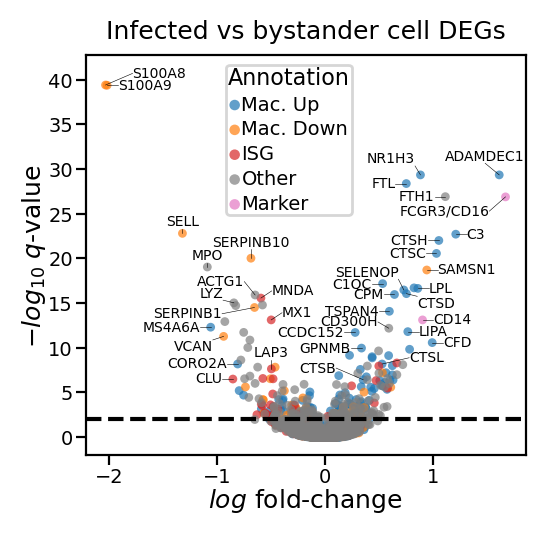

In [149]:
box_height=2.
box_width=2.2
left_space = .13
right_space = .98
bottom_space = .13
top_space = .9

ax_width = box_width
fig_width = ax_width/(right_space-left_space)
ax_height = box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(1, 1, fig,
                       left_space, bottom_space, right_space,top_space)



ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=True)

order = ['Mac. Up', 'Mac. Down','ISG', 'Other', 'Marker']
xvar = 'logFC'
yvar = 'logQ'
for k in order:
    g = infVsby_m3.loc[infVsby_m3['Annotation']==k, :]
    #ax.scatter(g[xvar], g[yvar], label=k, s=g['size'],
    #           edgecolor='None', alpha=.7, color=cat2color[k])
    ax.scatter(g[xvar], g[yvar], label=k, s=10,
               edgecolor='None', alpha=.7, color=cat2color[k])
    

ax.grid(False)
leg = ax.legend(loc=(.32, .6), fontsize=7,
                markerscale=1.2, title='Annotation',
                title_fontsize=8,handletextpad=0.1,
                labelspacing=.3, borderpad=.09)
ax.set_xlabel('$log$ fold-change', labelpad=.1)
ax.set_ylabel('$-log_{10}$ $q$-value', labelpad=.1)
ax.set_title('Infected vs bystander cell DEGs')




default_x_shift = 0
default_y_shift = .5
default_ha='center'
default_va='bottom'
labfontsize=5

ordered = infVsby_m3.loc[infVsby_m3[xvar]>0,:].sort_values(by=yvar, ascending=False)
up_to_label = list(ordered.index[ordered[yvar]>17])
up_to_label += ['CTSD', 'LPL', 'CPM', 'SELENOP', 'CD14', 'TSPAN4', 'LIPA', 'CCDC152', 'CFD', 'ENSMMUG00000045411',
               'GPNMB', 'CTSL', 'CTSB', 'MS4A6A']

ordered = infVsby_m3.loc[infVsby_m3[xvar]<0,:].sort_values(by=yvar, ascending=False)
down_to_label = list(ordered.index[ordered[yvar]>15])
down_to_label += ['SERPINB1', 'MX1', 'CORO2A', 'CLU', 'LAP3', 'VCAN']

rename = {'ENSMMUG00000045411':'CD300H', 'FCGR3':'FCGR3/CD16'}
genes_to_label = up_to_label + down_to_label

params = {
'above':{'x_shift':0, 'y_shift':1., 'ha':'center', 'va':'bottom'},
'right':{'x_shift':.1, 'y_shift':0., 'ha':'left', 'va':'center'},
'left':{'x_shift':-.1, 'y_shift':0., 'ha':'right', 'va':'center'},
'below':{'x_shift':0, 'y_shift':-.7, 'ha':'center', 'va':'top'},
'upper-right':{'x_shift':.1, 'y_shift':.8, 'ha':'left', 'va':'center'},
'lower-right':{'x_shift':.1, 'y_shift':-.3, 'ha':'left', 'va':'top'},
'upper-left':{'x_shift':-.1, 'y_shift':.3, 'ha':'right', 'va':'bottom'},
'lower-left':{'x_shift':-.1, 'y_shift':-.4, 'ha':'right', 'va':'top'},
}

category = {
'above':['SERPINB10', 'LAP3'],
'right':['S100A9', 'C3', 'SAMSN1', 'LPL', 'CD14', 'LIPA', 'CFD'],
'left':[ 'FTH1', 'CTSC', 'CTSH', 'FTL', 'C1QC', 'CPM', 'TSPAN4', 'CCDC152', 'GPNMB',
        'CORO2A', 'CLU', 'MS4A6A'],
'below':[],
'upper-right':['MNDA', 'MX1'],
'lower-right':['CTSD'],
'upper-left':['LYZ'],
'lower-left':['VCAN', 'VIM'],

}

other_param = {'ADAMDEC1':[-.13, 1.3, 'center', 'bottom'],
               'NR1H3':[-.05, 1, 'right', 'bottom'],
               'FCGR3':[-.15, -1.6, 'right', 'center'],
               'SELENOP':[-.05, 1.2, 'right', 'bottom'],
               'ENSMMUG00000045411':[-.1, .7, 'right', 'center'],
               'CTSL':[.25, .7, 'left', 'center'],
               'CTSB':[-.25, 1.3, 'right', 'center'],
               'S100A8':[.25, 1.3, 'left', 'center'],
               'SERPINB1':[-.3, -.7, 'right', 'center'],
               'ACTG1':[-.1, 1.5, 'right', 'center']

                }

gene2cat = {g:c for c in category.keys() for g in category[c]}

for g in genes_to_label:

    if g in other_param:
      (x_shift,y_shift,ha,va) = other_param[g]
      print(g, other_param[g])

    elif g in gene2cat:
      x_shift = params[gene2cat[g]]['x_shift']
      y_shift = params[gene2cat[g]]['y_shift']
      ha = params[gene2cat[g]]['ha']
      va = params[gene2cat[g]]['va']
    else:
      x_shift = default_x_shift
      y_shift = default_y_shift
      ha = default_ha
      va = default_va
      #continue


    if g in rename:
        tolab = rename[g]
    else:
        tolab = g

    if g == 'TSPAN4':
        print('here')
    ax.text(infVsby_m3.loc[g, xvar]+x_shift, infVsby_m3.loc[g, yvar]+y_shift,
          tolab, fontsize=labfontsize, va=va, ha=ha)

    yline = [infVsby_m3.loc[g, yvar], infVsby_m3.loc[g, yvar]+y_shift]
    xline = [infVsby_m3.loc[g, xvar], infVsby_m3.loc[g, xvar]+x_shift]
    ax.plot(xline, yline, color='k', linewidth=.2)

    
xlim = ax.get_xlim()


qthresh = .01
ax.hlines(-1*np.log10(qthresh), xmin=xlim[0], xmax=xlim[1], linestyle='--')
ax.set_xlim(xlim)


figure_file = os.path.join(results_dir, "DifferentialExpression.Invivo.BystanderVsInfected.Volcano.pdf")
fig.savefig(figure_file, dpi=200)

In [198]:
ordered = infVsby_m3.loc[infVsby_m3[xvar]<0,:].sort_values(by=yvar, ascending=False)
ordered.loc[:,['gene_symbol','logFC', 'logQ', 'Annotation']].head(30)

,gene_symbol,logFC,logQ,Annotation
primerid,,,,
S100A8,S100A8,-2.031446,39.405510,Mac. Down
S100A9,S100A9,-2.016819,39.376002,Mac. Down
SELL,SELL,-1.319994,22.799947,Mac. Down
SERPINB10,SERPINB10,-0.686204,20.017527,Mac. Down
MPO,MPO,-1.089701,19.035577,Other
ACTG1,ACTG1,-0.647646,15.902317,Other
MNDA,MNDA,-0.594048,15.557959,ISG
LYZ,LYZ,-0.844139,15.023352,Other
VIM,VIM,-0.579615,14.780205,Other


In [170]:


bystander_deg_output_full = os.path.join(results_dir, 'Monocyte_Bystander_Invivo_DEG_Full.tsv')
infVsby_m3.to_csv(bystander_deg_output_full, sep='\t', index=False)


bystander_deg_output = os.path.join(results_dir, 'Monocyte_Bystander_Invivo_DEG_ForSupp.tsv')
save_data = infVsby_m3[['gene_symbol','logFC', 'P_H', 'Q', 'Annotation']]
save_data.to_csv(bystander_deg_output, index=False, sep='\t')


In [173]:
save_data.loc[save_data['logFC']<0, :].head(50)

,gene_symbol,logFC,P_H,Q,Annotation
gene_symbol,,,,,
S100A8,S100A8,-2.031446,4.461840e-44,3.930881e-40,Mac. Down
S100A9,S100A9,-2.016819,9.551066e-44,4.207245e-40,Mac. Down
SELL,SELL,-1.319994,1.439351e-26,1.585085e-23,Mac. Down
SERPINB10,SERPINB10,-0.686204,1.308212e-23,9.604454e-21,Mac. Down
MPO,MPO,-1.089701,1.359537e-22,9.213474e-20,Other
ACTG1,ACTG1,-0.647646,2.984878e-19,1.252227e-16,Other
MNDA,MNDA,-0.594048,6.910158e-19,2.767204e-16,ISG
LYZ,LYZ,-0.844139,2.473999e-18,9.476493e-16,Other
VIM,VIM,-0.579615,4.518872e-18,1.658803e-15,Other


In [183]:
save_data.loc[['LGALS1', 'RNASE2', 'SRGN', 'CSTA', 'AZU1', 'PLAC8', 'CTSL', 'CTSB', 'GNPTAB', 'NPC1'], :]

,gene_symbol,logFC,P_H,Q,Annotation
gene_symbol,,,,,
LGALS1,LGALS1,-0.439137,1.290564e-03,2.711189e-02,Other
RNASE2,RNASE2,-0.062651,1.728243e-04,5.380148e-03,Other
SRGN,SRGN,-0.026126,5.084696e-01,9.910657e-01,Mac. Down
CSTA,CSTA,-0.307560,1.480594e-02,1.638697e-01,Other
AZU1,AZU1,-0.235189,3.365027e-05,1.391826e-03,Other
PLAC8,PLAC8,-0.376904,7.645635e-08,6.603730e-06,Mac. Down
CTSL,CTSL,0.527138,3.774437e-11,6.690649e-09,Mac. Up
CTSB,CTSB,0.351719,3.220840e-09,3.819189e-07,Mac. Up
GNPTAB,GNPTAB,0.288396,5.359226e-05,2.079946e-03,Mac. Up


## Score cells by monocyte to macrophage trajectory

In [111]:
adata_raw.var['Combined_Blacklist'].value_counts()

False    16946
Name: Combined_Blacklist, dtype: int64

In [112]:
ind = (adata_raw.obs['Subclustering_reduced']=='Mono')
adata_mono = adata_raw[ind, :]
sc.pp.filter_genes(adata_mono, min_cells=10)
sc.pp.normalize_per_cell(adata_mono, counts_per_cell_after=10000)
sc.pp.log1p(adata_mono)

filtered out 5247 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [113]:
infVsby_m3.head()

,gene_symbol,logFC,P_H,P_C,P_D,Q,Infection_DE_Annotation,DongEtAl_Annotation,SaeedEtAl_Annotation,Italiani_M1_gene,Italiani_M2_gene,Italiani_M1orM2_gene,ISG,Annotation,logQ
gene_symbol,,,,,,,,,,,,,,,
S100A8,S100A8,-2.031446,4.461840e-44,2.941037e-33,1.055477e-13,3.930881e-40,Significant Down,Significant Down,Significant Down,False,True,True,False,Mac. Down,39.405510
S100A9,S100A9,-2.016819,9.551066e-44,5.671494e-35,1.248295e-11,4.207245e-40,Significant Down,Not Significant,Significant Down,False,False,False,False,Mac. Down,39.376002
ADAMDEC1,ADAMDEC1,1.610543,1.583800e-33,6.526650e-17,1.999127e-19,4.533046e-30,Significant Up,Significant Up,Significant Up,False,True,True,False,Mac. Up,29.343610
NR1H3,NR1H3,0.881882,2.058136e-33,2.460906e-03,1.343855e-32,4.533046e-30,Significant Up,Significant Up,Significant Up,False,True,True,False,Mac. Up,29.343610
FTL,FTL,0.750957,2.393853e-32,1.401836e-30,2.397972e-04,4.217970e-29,Significant Up,Not Significant,Significant Up,False,False,False,False,Mac. Up,28.374897


In [114]:
siglog2fc = mono2mac_allgenes_dedup.loc[mono2mac_allgenes_dedup['DongEtAl_Annotation'].isin(['Significant Up', 'Significant Down']),'log2 (fold change)']
mac_associated = infVsby_m3.index[infVsby_m3['Annotation'].isin(['Mac. Down', 'Mac. Up'])]
siglog2fc = siglog2fc.loc[list(set(siglog2fc.index).intersection(mac_associated))]

In [150]:
siglog2fc

gene symble
CD2       -6.09753
MGMT       3.74333
SUCLG2     3.68766
SLC22A4   -6.32363
BACH1     -2.66594
            ...   
ABCC5      3.91439
PF4       -9.43950
DHRS11     4.36588
BCL2L1     2.52237
CADM1      3.43852
Name: log2 (fold change), Length: 618, dtype: float64

In [115]:
mono_diff_expr = pd.DataFrame(adata_mono[:,siglog2fc.index].X.todense(), index=adata_mono.obs.index, columns=siglog2fc.index)

In [116]:
mono_diff_obs = adata_mono.obs.copy()
mono_diff_obs['DPIc2'] = mono_diff_obs['DPIc'].astype(str).replace({'7':'7-8', '8':'7-8'})
genes = ['NR1H3']
for g in genes:
    mono_diff_obs[g] = adata_mono.obs_vector(g)

In [180]:
mono_diff_obs['diff_score'] = mono_diff_expr.dot(siglog2fc)

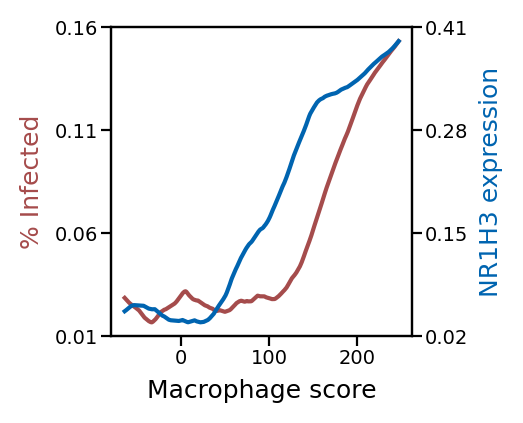

In [181]:
window=400

ind = mono_diff_obs['DPIc'].isin([ '6', '7', '8'])
X = mono_diff_obs.loc[ind,['diff_score', 'Ebola_Positive'] + genes].sort_values(by='diff_score')

window=400
probability_infected = X.rolling(window, center=True, win_type='triang').mean().dropna()


fig = plt.figure(constrained_layout=True, figsize=(2.5,2), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.1,
                       bottom=.1, right=.9, top=.9)

ax = fig.add_subplot(gs[0], 
                     ylabel='', xlabel='',
                     title='')

ax.plot(probability_infected['diff_score'], probability_infected['Ebola_Positive'],
        c=[0.49803922, 0.        , 0.    , .7    ])
ax.set_ylabel('% Infected', color=[0.49803922, 0.        , 0.    , .7    ])

ax2 = ax.twinx()

ax2.plot(probability_infected['diff_score'], probability_infected['NR1H3'], color='#0064B0')
ax2.set_ylabel('NR1H3 expression', color='#0064B0')

ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 4))
ax2.set_yticks(np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 4))
ax.set_yticklabels(['%.2f' % x for x in np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 4)])
ax2.set_yticklabels(['%.2f' % x for x in np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 4)])

ax.set_xlabel('Macrophage score')
ax.grid(False)
ax2.grid(False)

figure_file = os.path.join(results_dir, "monoinfectprob.vs.differentiation.invivo.NR1H3marker.pdf")
fig.savefig(figure_file, dpi=200)

In [156]:
probability_infected

,diff_score,Ebola_Positive,NR1H3
NHP23.D006.FRZ-MDCK.a2.std_88_Novaseq_20190808_GCAGACTCTCAG,-64.468602,0.030275,0.050938
NHP23.D006.FRZ-MDCK.a2.std_88_Novaseq_20190808_GGAATTCGATCG,-64.166891,0.030138,0.051168
NHP23.D006.FRZ-MDCK.a1.std_88_Novaseq_20190808_ACAAATTAGCTG,-63.868557,0.030012,0.051422
NHP24.D006.FRZ.a3.std_88_Novaseq_20190701_TACGTCTGATAG,-63.572906,0.029887,0.051676
NHP23.D006.FRZ-MDCK.a2.std_88_Novaseq_20190808_TAGATCCTATGC,-63.279806,0.029762,0.051929
...,...,...,...
NHP23.D006.FRZ-MDCK.a5.std_88_Novaseq_20190809_GGACGCTTATGA,244.553372,0.147288,0.390497
NHP22.D006.FRZ-MDCK.a3.std_88_Novaseq_20190808_GTACTAGACTCC,245.336349,0.147712,0.391529
NHP23.D006.FRZ-MDCK.a1.std_88_Novaseq_20190808_CCCCCTGCGGAA,246.126980,0.148163,0.392587
NHP23.D006.FRZ-MDCK.a6.std_88_Novaseq_20190809_CTCTCCAAATCT,246.925268,0.148638,0.393670


In [86]:
diff_score_fn = os.path.join(adir, 'macrophage_differentiation_score.tsv')
mono_diff_obs.to_csv(diff_score_fn, sep='\t')

## Continuous EBOV analysis

In [102]:
adata_full = sc.AnnData(X=adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)

In [103]:
'EBOV-NP' in adata_raw.var.index

False

In [104]:
metadata = adata_raw.obs
infectedcells = metadata.index[(metadata['Ebola_Positive']==True) & metadata['DPIc'].isin(['4', '5', '6', '7', '8'])  & (metadata['SubclusteringGroup']=='Mono')]
geneorder = ['EBOV-NP', 'EBOV-VP35','EBOV-VP40', 'EBOV-GP','EBOV-VP30', 'EBOV-VP24', 'EBOV-L']
invivo_ebov_data = pd.DataFrame(adata_full[:,geneorder].X.todense(), index=adata_full.obs.index, columns=geneorder)

In [105]:
numwindow = 50


invivo_ebov_data_toplot = pd.concat([invivo_ebov_data.loc[infectedcells, geneorder], metadata.loc[infectedcells, ['percent_EBOV']]], axis=1)
invivo_ebov_data_toplot = invivo_ebov_data_toplot.sort_values(by='percent_EBOV')
ebov_pos_data_combined_windowed = invivo_ebov_data_toplot.rolling(window=numwindow, center=True, win_type='triang').sum()
ebov_pos_data_combined_windowed_mean = invivo_ebov_data_toplot.rolling(window=numwindow, center=True, win_type='triang').mean()
ebov_pos_data_combined_windowed['percent_EBOV'] = ebov_pos_data_combined_windowed_mean['percent_EBOV']*100
ebov_pos_data_combined_windowed = ebov_pos_data_combined_windowed.dropna()
ebov_pos_data_combined_windowed_norm = ebov_pos_data_combined_windowed.copy()


X = ebov_pos_data_combined_windowed_norm.iloc[:,:-1].copy()
P = X.div(X.sum(axis=1), axis=0)
ebov_pos_data_combined_windowed_norm.iloc[:,:-1] = P

ebov_pos_data_combined_windowed_norm_SE = (P*(1-P)).div(X.sum(axis=1), axis=0)
ebov_pos_data_combined_windowed_norm_SE = ebov_pos_data_combined_windowed_norm_SE.apply(np.sqrt) #*1.96

ebov_pos_data_combined_windowed_norm_SE['percent_EBOV'] = ebov_pos_data_combined_windowed_norm['percent_EBOV']

ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'] = ebov_pos_data_combined_windowed_norm['percent_EBOV'].apply(np.log10)
ebov_pos_data_combined_windowed_norm_SE['log10_percent_EBOV'] = ebov_pos_data_combined_windowed_norm_SE['percent_EBOV'].apply(np.log10)

In [106]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

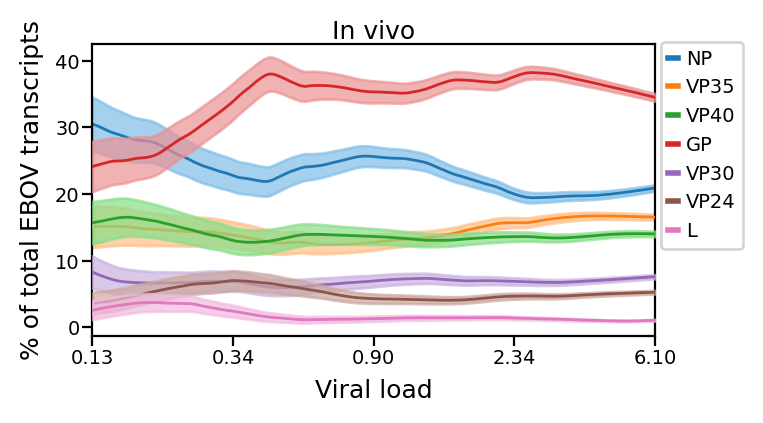

In [108]:
fig = plt.figure(constrained_layout=True, figsize=(3.7,2), dpi=200)
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.8, top=.9)
ax = fig.add_subplot(gs[0])

quantile = ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'].quantile([0, .25, .5, .75, 1])


#(fig,ax) = plt.subplots(1,1,figsize=(6,3), dpi=200)
zorder = 0
for (i,g) in enumerate(geneorder):
    fillcolor = lighten_color(palettable.tableau.Tableau_10.mpl_colors[i], amount=.5)
    ax.fill_between(ebov_pos_data_combined_windowed_norm_SE['log10_percent_EBOV'],
                    (ebov_pos_data_combined_windowed_norm[g]-ebov_pos_data_combined_windowed_norm_SE[g])*100,
                    (ebov_pos_data_combined_windowed_norm[g]+ebov_pos_data_combined_windowed_norm_SE[g])*100,
                    color=fillcolor, alpha=0.7,
                    edgecolor=palettable.tableau.Tableau_10.mpl_colors[i],
                    zorder=zorder)
    zorder+=1

    ax.plot(ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'], ebov_pos_data_combined_windowed_norm[g]*100,
               color=palettable.tableau.Tableau_10.mpl_colors[i],
            label=g.split('-')[1], linewidth=1, zorder=zorder)
    zorder+=1

    
    
    
    #ax.plot(ebov_pos_data_combined_windowed_norm['percent_EBOV_scale'], ebov_pos_data_combined_windowed_norm[g]*100,
    #           color='k', label=None, linewidth=.1)
    
leg = ax.legend(fontsize=7, loc=(1.01,0.3), markerscale=1)
ax.set_xlabel('Viral load')
ax.set_ylabel('% of total EBOV transcripts')
#ax.set_title('Ebola transcript abundance over life-cycle')

for line in leg.get_lines():
    line.set_linewidth(2.0)

xmin=ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'].min()
xmax=ebov_pos_data_combined_windowed_norm['log10_percent_EBOV'].max()
vals = np.logspace(start=xmin, stop=xmax, num=5, endpoint=True, base=10)
#vals = [ 0.05618414,  0.27915831,  1.38703487,  6.89166563, 34.24214936]
pos = [np.log10(x) for x in vals]


ax.set_xticks(pos)
ax.set_xticklabels(['%.2f' % x for x in vals])
ax.set_xlim([pos[0], pos[-1]])
ax.set_title('In vivo', pad=0)
ax.grid(False)

figure_file = os.path.join(results_dir, "EbolaGenePercentage.InVivo.Line.pdf")
fig.savefig(figure_file, dpi=200)

## Viral load in infected cells

In [9]:
adir_local = '../../../../data/InVivo/Seqwell/'
dedir = os.path.join(adir_local, 'DE_ViralLoad')
if not os.path.exists(dedir): os.mkdir(dedir)
    
de_infiles = os.path.join(dedir, 'genefiles')
if not os.path.exists(de_infiles): os.mkdir(de_infiles)
    
de_results = os.path.join(dedir, 'results')
if not os.path.exists(de_results): os.mkdir(de_results)

In [10]:
adata_raw.var['Combined_Blacklist'].value_counts()

False    16946
Name: Combined_Blacklist, dtype: int64

In [11]:
from sklearn.preprocessing import scale

mono_dpi5to8 = (adata_raw.obs['Subclustering_reduced']=='Mono') & (adata_raw.obs['DPIc'].isin(['5','6','7','8'])) & (adata_raw.obs['log10_EBOV_TPT']>0)

adata_ct = adata_raw[mono_dpi5to8,:]
adata_ct.obs['is_fresh'] = adata_ct.obs['frz_status'].replace({'fresh':1, 'FRZ':0})
adata_ct.obs['is_fresh_scale'] = scale(adata_ct.obs['is_fresh'])
adata_ct.obs['soup_usage_scale'] = scale(adata_ct.obs['Soup_Usage'])
adata_ct.obs['percent_mito_scale'] = scale(adata_ct.obs['percent_mito'])
        
sc.pp.filter_genes(adata_ct, min_cells=(.05*adata_ct.shape[0]))
adata_ct.obs['cngeneson'] =  scale((adata_ct.X>0).sum(axis=1)).reshape(-1)        
sc.pp.normalize_per_cell(adata_ct, counts_per_cell_after=10000)
sc.pp.log1p(adata_ct)
X = pd.DataFrame(adata_ct.X.todense(), index=adata_ct.obs.index, columns=adata_ct.var.index).T
X.to_csv(os.path.join(dedir, 'InfectedMonocyte.expression.csv'))
adata_ct.obs.to_csv(os.path.join(dedir, 'InfectedMonocyte.celldata.csv'))
adata_ct.var.to_csv(os.path.join(dedir, 'InfectedMonocyte.genedata.csv'))

Trying to set attribute `.obs` of view, copying.


filtered out 10272 genes that are detectedin less than 10.700000000000001 cells
normalizing by total count per cell


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [96]:
ncores =7
testvar = 'log10_EBOV_TPT'
covars = ['is_fresh_scale', 'cngeneson', 'percent_mito_scale']
covarstr = ','.join(covars)

exprfn = os.path.join(dedir, 'InfectedMonocyte.expression.csv')
celldatfn = os.path.join(dedir, 'InfectedMonocyte.celldata.csv')
genedatfn = os.path.join(dedir, 'InfectedMonocyte.genedata.csv')
resultsfn = os.path.join(dedir, 'InfectedMonocyte_Continuous.DE.csv')
cmd = 'Rscript ../../../Code/run_mast.R %s %s %s %s %d %s %s' % (exprfn, celldatfn, genedatfn, resultsfn, ncores, testvar, covarstr)
print(cmd)
!{cmd}

Rscript ../../../Code/run_mast.R ../../../../data/InVivo/Seqwell/DE_ViralLoad/InfectedMonocyte.expression.csv ../../../../data/InVivo/Seqwell/DE_ViralLoad/InfectedMonocyte.celldata.csv ../../../../data/InVivo/Seqwell/DE_ViralLoad/InfectedMonocyte.genedata.csv ../../../../data/InVivo/Seqwell/DE_ViralLoad/InfectedMonocyte_Continuous.DE.csv 7 log10_EBOV_TPT is_fresh_scale,cngeneson,percent_mito_scale
~log10_EBOV_TPT + is_fresh_scale + cngeneson + percent_mito_scale
`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name et is log-transformed.
 Completed [=====>--------------------------------------]  14% with 0 failures
Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...
 Completed [=====>--------------------------------------]  14% with 0 failures Completed [====>---------------------------------------]  10% wit

In [5]:
adir_local = '../../../../data/InVivo/Seqwell/'
dedir = os.path.join(adir_local, 'DE_ViralLoad')
resultsfn = os.path.join(dedir, 'InfectedMonocyte_Continuous.DE.csv')

contInf = pd.read_csv(resultsfn).sort_values(by='P_H')
contInf.index = contInf['primerid']

(_,q,_,_) = multipletests(contInf['P_H'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
contInf['Q'] = q
contInf['logQ'] = contInf['Q'].apply(np.log10)*-1

contInf.loc[:,['logFC', 'P_H', 'Q']].iloc[:50,:]

,logFC,P_H,Q
primerid,,,
MX1,-0.525761,1.115168e-12,7.442634e-09
OAS2,-0.466175,2.256158e-10,7.528798e-07
GBP2,-0.381912,4.766162e-09,1.060312e-05
MX2,-0.458873,7.383717e-09,1.231973e-05
ISG15,-0.374578,1.202026e-08,1.539728e-05
DYNLL1,0.504518,1.384232e-08,1.539728e-05
IFI44,-0.244425,1.486166e-07,1.416953e-04
FTH1,0.657079,4.020280e-07,3.353919e-04
OASL,-0.048556,8.200814e-07,6.081359e-04


In [8]:
contInf.loc['IARS', :]

primerid         IARS
logFC       0.0593257
P_H          0.518283
P_C          0.953575
P_D            0.2522
Q                   1
logQ               -0
Name: IARS, dtype: object

In [15]:
from scipy.stats import spearmanr
X = pd.DataFrame(adata_ct.X.todense(), index=adata_ct.obs.index, columns=adata_ct.var.index).T
spearman_res = {}
for i in X.index:
    (R,P) = spearmanr(X.loc[i,:], adata_ct.obs['log10_EBOV_TPT'])
    spearman_res[i] = [R,P]

spearman_res = pd.DataFrame.from_dict(spearman_res, columns=['Spearman_R', 'Spearman_P'], orient='index')
spearman_res.head()

,Spearman_R,Spearman_P
CCNF,-0.083682,0.222795
NAGA,-0.113279,0.098381
BET1,-0.080642,0.240114
PTPRC,-0.009574,0.889258
EMC7,-0.144711,0.034371


In [16]:
contInf = pd.merge(left=contInf, right=spearman_res, left_index=True, right_index=True, how='left')

In [17]:
gsetfn = '../../../../data/Genesets/msigdb/c2andh.all.v6.2.symbols.gmt'
gset_c2andH, allgenes = load_geneset(gsetfn,  genes=list(contInf.index), minsize=10)

literature_interferon = gset_c2andH['HECKER_IFNB1_TARGETS'].union(gset_c2andH['BROWNE_INTERFERON_RESPONSIVE_GENES']).union(gset_c2andH['MOSERLE_IFNA_RESPONSE']).union(gset_c2andH['HALLMARK_INTERFERON_ALPHA_RESPONSE']).union(gset_c2andH['HALLMARK_INTERFERON_GAMMA_RESPONSE'])
len(literature_interferon)

199

In [18]:
contInf.loc[contInf['logFC']>0,:].head(10)

,primerid,logFC,P_H,P_C,P_D,Q,logQ,Spearman_R,Spearman_P
primerid,,,,,,,,,
DYNLL1,DYNLL1,0.504518,1.384232e-08,1.475546e-07,0.003418,0.000015,4.812556,0.236902,0.000474
FTH1,FTH1,0.657079,4.020280e-07,4.378168e-06,0.003832,0.000335,3.474447,0.297139,0.000010
SAMSN1,SAMSN1,0.443929,1.067448e-06,6.492577e-06,0.007441,0.000712,3.147267,0.228170,0.000772
SDC2,SDC2,0.133884,4.074570e-06,8.487497e-03,0.000023,0.002092,2.679475,0.160953,0.018466
CPM,CPM,0.245600,6.583520e-05,5.093651e-02,0.000085,0.019972,1.699578,0.176699,0.009593
SNX10,SNX10,0.365724,1.925734e-04,4.125074e-04,0.031319,0.042841,1.368139,0.148041,0.030395
FTL,FTL,0.286898,5.645233e-04,2.529984e-04,0.210313,0.101828,0.992134,0.208049,0.002219
CSDE1,CSDE1,0.386235,9.130408e-04,1.254128e-02,0.005328,0.132470,0.877881,0.158115,0.020665
PSMA6,PSMA6,0.316319,9.654552e-04,1.366274e-02,0.005211,0.137095,0.862980,0.087806,0.200740


In [25]:
contInf['Continuous_Category'] = 'Other'
ind = contInf['primerid'].isin(literature_interferon)
contInf.loc[:, 'ISG'] = ind
contInf.loc[ind, 'Continuous_Category'] = 'ISG'

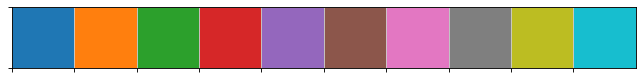

In [26]:
sns.palplot(palettable.tableau.Tableau_10.hex_colors)
colors = palettable.tableau.Tableau_10.hex_colors
cat2color = {'Mac. Up':colors[0], 'Mac. Down':colors[1], 'Other':colors[7], 'ISG':colors[3], 'Marker':colors[6]}

In [27]:
box_height=2.2
box_width=2.2
left_space = .15
right_space = .98
bottom_space = .13
top_space = .9

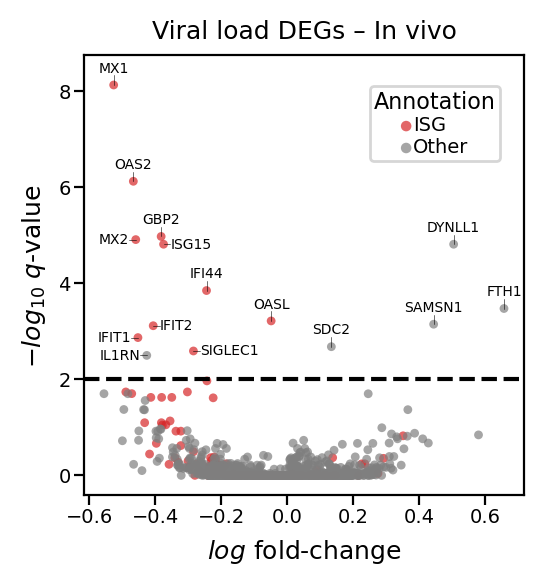

In [28]:
ax_width = box_width
fig_width = ax_width/(right_space-left_space)
ax_height = box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(1, 1, fig,
                       left_space, bottom_space, right_space,top_space)



ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=True)

order = ['ISG', 'Other']
xvar = 'logFC'
yvar = 'logQ'
for k in order:
    g = contInf.loc[contInf['Continuous_Category']==k, :]
    #ax.scatter(g[xvar], g[yvar], label=k, s=g['size'],
    #           edgecolor='None', alpha=.7, color=cat2color[k])
    ax.scatter(g[xvar], g[yvar], label=k, s=10,
               edgecolor='None', alpha=.7, color=cat2color[k],
               rasterized=True)
    
ax.grid(False)
leg = ax.legend(loc=(.65, .76), fontsize=7,
                markerscale=1.2, title='Annotation',
                title_fontsize=8,handletextpad=0.1,
                labelspacing=.15, borderpad=.2)
ax.set_xlabel('$log$ fold-change')
ax.set_ylabel('$-log_{10}$ $q$-value')

ax.set_title('Viral load DEGs – In vivo')


default_x_shift = 0
default_y_shift = .2
default_ha='center'
default_va='bottom'
labfontsize=5


ordered = contInf.loc[contInf[xvar]>0,:].sort_values(by=yvar, ascending=False)
up_to_label = list(ordered.index[ordered[yvar]>2])

ordered = contInf.loc[contInf[xvar]<0,:].sort_values(by=yvar, ascending=False)
down_to_label = list(ordered.index[ordered[yvar]>2])

rename = {'ENSMMUG00000045411':'CD300H'}
genes_to_label = up_to_label + down_to_label

params = {
'above':{'x_shift':0, 'y_shift':.2, 'ha':'center', 'va':'bottom'},
'right':{'x_shift':.02, 'y_shift':0., 'ha':'left', 'va':'center'},
'left':{'x_shift':-.02, 'y_shift':0., 'ha':'right', 'va':'center'},
'below':{'x_shift':0, 'y_shift':-.7, 'ha':'center', 'va':'top'},
'upper-right':{'x_shift':.02, 'y_shift':.2, 'ha':'left', 'va':'bottom'},
'lower-right':{'x_shift':.02, 'y_shift':-.3, 'ha':'left', 'va':'top'},
'upper-left':{'x_shift':-.02, 'y_shift':.2, 'ha':'right', 'va':'bottom'},
'lower-left':{'x_shift':-.02, 'y_shift':-.4, 'ha':'right', 'va':'top'},
}

category = {
'above':['DYNLL1', 'OAS2', 'IFI44'],
'right':['IFIT2', 'ISG15', 'WARS', 'SIGLEC1'],
'left':[ 'APOL2', 'MX2', 'IL1RN', 'IFIT1'],
'below':[],
'upper-right':[],
'lower-right':[],
'upper-left':[],
'lower-left':['STAP1'],

}

other_param = {'IFI27':[0, .27, 'center', 'bottom'],
               'RAB44':[-.08, .6, 'right', 'center'],
               'GIMAP8':[-.05, .55, 'center', 'bottom'],
               'PSMB9':[.13, .4, 'left', 'center'],
               'LAP3':[-.02, .4, 'center', 'bottom'],
               'PLAC8':[-.05, .2, 'right', 'center']}



gene2cat = {g:c for c in category.keys() for g in category[c]}

for g in genes_to_label:

    if g in other_param:
      (x_shift,y_shift,ha,va) = other_param[g]
      print(g, other_param[g])

    elif g in gene2cat:
      x_shift = params[gene2cat[g]]['x_shift']
      y_shift = params[gene2cat[g]]['y_shift']
      ha = params[gene2cat[g]]['ha']
      va = params[gene2cat[g]]['va']
    else:
      x_shift = default_x_shift
      y_shift = default_y_shift
      ha = default_ha
      va = default_va
      #continue



    if g in rename:
      tolab = rename[g]
    else:
      tolab = g

    ax.text(contInf.loc[g, xvar]+x_shift, contInf.loc[g, yvar]+y_shift,
          tolab, fontsize=labfontsize, va=va, ha=ha)

    yline = [contInf.loc[g, yvar], contInf.loc[g, yvar]+y_shift]
    xline = [contInf.loc[g, xvar], contInf.loc[g, xvar]+x_shift]
    ax.plot(xline, yline, color='k', linewidth=.2)
    
xlim = ax.get_xlim()


qthresh = .01
ax.hlines(-1*np.log10(qthresh), xmin=xlim[0], xmax=xlim[1], linestyle='--')
ax.set_xlim(xlim)

figure_file = os.path.join(results_dir, "DifferentialExpression.Invivo.ViralLoad.Volcano.pdf")
fig.savefig(figure_file, dpi=300)

In [47]:
contInf.loc[['DYNLL1', 'HSPA5', 'NFE2L1', 'DDIT3', 'IARS'], :]

,primerid,logFC,P_H,P_C,P_D,Q,logQ,Spearman_R,Spearman_P,Continuous_Category,Gene_ID,ISG,Statistic,Sig_Down,Sig_Up
primerid,,,,,,,,,,,,,,,
DYNLL1,DYNLL1,0.504518,1.384232e-08,1.475546e-07,0.003418,0.000015,4.812556,0.236902,0.000474,Other,ENSMMUG00000001194,False,0.504518,False,True
HSPA5,HSPA5,0.255438,4.353691e-02,5.314406e-02,0.111777,0.836645,0.077459,0.132014,0.053814,Other,ENSMMUG00000005217,False,0.255438,False,True
NFE2L1,NFE2L1,0.096512,3.325205e-01,9.691170e-01,0.137956,1.000000,-0.000000,-0.058045,0.398188,Other,ENSMMUG00000021935,False,0.000000,False,False
DDIT3,DDIT3,0.088111,5.265558e-01,6.282750e-01,0.305878,1.000000,-0.000000,-0.009214,0.893405,Other,ENSMMUG00000011286,False,0.000000,False,False
IARS,IARS,0.059326,5.182832e-01,9.535751e-01,0.252200,1.000000,-0.000000,-0.031518,0.646607,Other,ENSMMUG00000004628,False,0.000000,False,False


In [48]:
contInf['Gene_ID'] = adata_raw.var.loc[contInf.index, 'gene_id']

In [49]:
contInf[['primerid', 'Gene_ID', 'logFC', 'P_H', 'Q','Spearman_R', 'Spearman_P', 'ISG']].rename(columns={'P_H':'P', 'primerid':'Gene_Symbol'}).to_csv(os.path.join(results_dir, 'Monocyte_ViralLoad_Invivo_DEG.tsv'), sep='\t', index=False)

In [50]:
gsetfn = '../../../../data/Genesets/msigdb/c2andh.all.v6.2.symbols.gmt'
gset_c2andH, allgenes = load_geneset(gsetfn,  genes=contInf.index, minsize=10)
#cont24['Match_ID'] = cont24['primerid'].copy()
#ind = ~cont24.index.isin(allgenes) & adata_raw.var.loc[cont24.index, 'human_ortholog_name'].isin(allgenes)
#ind = cont24.index[ind]
#cont24.loc[ind, 'Match_ID'] = adata_raw.var.loc[ind, 'human_ortholog_name']
#vc = cont24['Match_ID'].value_counts()

In [51]:
contInf['Statistic'] = contInf['logFC'].copy()
contInf.loc[contInf['P_H']>0.1, 'Statistic'] = 0
contInf['Down'] = (contInf['P_H']<.05) & (contInf['logFC']<0)
contInf['Up'] = (contInf['P_H']<.05) & (contInf['logFC']>0)

In [52]:
from geneset_testing import fishertestbygep

In [55]:
gsettest = fishertestbygep(gset_c2andH,  contInf[['Down', 'Up']])

Down
Up


In [57]:
for c in ['Up', 'Down']:
    (_,q,_,_) = multipletests(gsettest.loc[:,(c, 'P')], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
    gsettest[(c,'Q')] = q
gsettest.sort_index(axis=1, inplace=True)

In [58]:
gsettest['Up'].sort_values(by='P').head(20)

,OR,P,Q
RUTELLA_RESPONSE_TO_HGF_UP,4.76205,5.57919e-08,0.000156669
MCLACHLAN_DENTAL_CARIES_UP,6.45878,1.04901e-07,0.000156669
NAKAYAMA_SOFT_TISSUE_TUMORS_PCA1_UP,10.7499,1.34855e-05,0.0092849
RUTELLA_RESPONSE_TO_HGF_VS_CSF2RB_AND_IL4_UP,3.59542,1.53957e-05,0.0092849
VECCHI_GASTRIC_CANCER_ADVANCED_VS_EARLY_UP,10.0749,1.9412e-05,0.0092849
PAPASPYRIDONOS_UNSTABLE_ATEROSCLEROTIC_PLAQUE_UP,10.0749,1.9412e-05,0.0092849
SCHUETZ_BREAST_CANCER_DUCTAL_INVASIVE_UP,4.91893,2.17591e-05,0.0092849
ONDER_CDH1_TARGETS_2_DN,4.77142,5.94172e-05,0.0204976
SMID_BREAST_CANCER_LUMINAL_B_DN,4.37551,6.17604e-05,0.0204976
SENESE_HDAC1_TARGETS_UP,3.41017,7.44928e-05,0.0218599


In [59]:
outfn = os.path.join(results_dir, 'Monocyte_ViralLoad_Invivo_GenesetEnrichment.tsv')

In [60]:
gsettest.to_csv(outfn, sep='\t')